/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Federated Round 1/100
  Training Participant 1
  Training Participant 2
  Training Participant 3


<ipython-input-1-2b00ab5203e5>:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_df = pd.concat([auc_df, new_row], ignore_index=True)


Federated Round 2/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 3/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 4/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 5/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 6/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 7/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 8/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 9/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 10/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 11/100
  Training Participant 1
  Training Participant 2
  Training Participant 3
Federated Round 12/100
  Tra

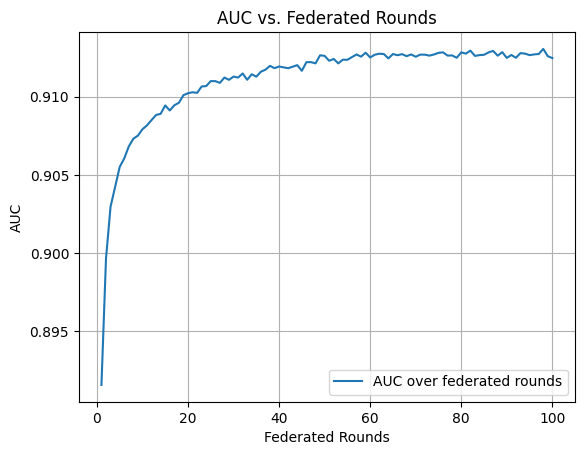

   Federated Round       AUC
0                1  0.891577
1                2  0.899657
2                3  0.902971
3                4  0.904225
4                5  0.905502
..             ...       ...
95              96  0.912698
96              97  0.912723
97              98  0.913048
98              99  0.912583
99             100  0.912463

[100 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from google.colab import files

# Preprocessing Adult dataset
def load_adult_data():
    adult = fetch_openml(data_id=1590, as_frame=True)
    X, y = adult.data, adult.target
    X = pd.get_dummies(X, drop_first=True)
    # Target to binary
    y = (y == '>50K').astype(int)
    return X, y

X, y = load_adult_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor datasets better to train with Pytorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
tensor_split_data = [{'train': train_dataset, 'test': test_dataset} for _ in range(3)]

# Our GlobalModel class
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index]  # We extract the segment of the input corresponding to the active participant's features only
                segment_output = segment(segment_input)
                segment_outputs.append(segment_output)
            else:
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device)) # Non-active segments are appended with zero
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output

# Training function
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)  # Segments not corresponding to the active participant are replaced with zero tensors
        optimizer.zero_grad()
        output = model(data, active_segments=[participant_id])
        loss = nn.BCEWithLogitsLoss()(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()

# Function to safely initialize or get gradients
def safe_gradient(parameter):
    if parameter.grad is not None:
        return parameter.grad.data
    else:
        return torch.zeros_like(parameter.data)

# Selective gradient exchange function
def selective_exchange_gradients(models, input_sizes, hidden_sizes):
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()
    final_start = param_indices[-1]
    if final_start < len(list(models[0].parameters())):
        for param_idx in range(final_start, len(list(models[0].parameters()))):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    if param_idx < len(list(model.parameters())):
                        list(model.parameters())[param_idx].grad = avg_grad.clone()

# Evaluation function
def evaluate(models, device, test_loader, return_auc_only=False):
    with torch.no_grad():
        all_preds = []
        all_targets = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            outputs = torch.zeros(data.size(0), 1, device=device)
            for model in models:
                output = model(data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)
            all_preds.extend(torch.sigmoid(outputs).view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

        # AUC
        auc = roc_auc_score(all_targets, all_preds)
        if return_auc_only:
            return auc
        print(f'AUC: {auc:.4f}')
        return auc

# Model and Training parameters
input_sizes = [X_train.shape[1] // 3] * 2 + [X_train.shape[1] - 2 * (X_train.shape[1] // 3)]
hidden_sizes = [10] * 3
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(3)]
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

federated_rounds = 100
epochs_per_round = 1
auc_history = []

# DataFrame to store AUC values
auc_df = pd.DataFrame(columns=['Federated Round', 'AUC'])

# Test loader as it is
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for federated_round in range(federated_rounds):
    print(f"Federated Round {federated_round + 1}/{federated_rounds}")
    for participant_id in range(3):
        print(f"  Training Participant {participant_id + 1}")
        train_loader = DataLoader(tensor_split_data[participant_id]['train'], batch_size=64, shuffle=True)
        for epoch in range(1, epochs_per_round + 1):
            train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id)


    selective_exchange_gradients(models, input_sizes, hidden_sizes)

    # AUC after each federated round
    auc = evaluate(models, device, test_loader, return_auc_only=True)
    auc_history.append(auc)
    new_row = pd.DataFrame({'Federated Round': [federated_round + 1], 'AUC': [auc]})
    auc_df = pd.concat([auc_df, new_row], ignore_index=True)

# AUC values saving to a CSV file
auc_df.to_csv('auc_values.csv', index=False)

# AUC vs. Federated Rounds Plot
plt.figure()
plt.plot(range(1, len(auc_history) + 1), auc_history, label='AUC over federated rounds')
plt.xlabel('Federated Rounds')
plt.ylabel('AUC')
plt.title('AUC vs. Federated Rounds')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# DataFrame
print(auc_df)

# CSV file download
#files.download('auc_values.csv')
